In [1]:
import mediapy as media
import cv2
import numpy as np

In [2]:
large_map = cv2.imread("../large_map.png")
large_map.shape

(10200, 13200, 3)

In [3]:
video_capture = cv2.VideoCapture(r"D:\Vid\2025-07-17 23-29-11.mp4")
success, frame = video_capture.read()
frames = []
while success:
    frames.append(frame)
    success, frame = video_capture.read()


In [4]:
frames = np.stack(frames[::5]).astype(np.float32).mean(axis=-1)/255

In [5]:
orig = frames[0]
media.write_image('frame.png', orig)

In [6]:
diff = np.abs(frames-orig[None]).mean(-1).mean(-1)

In [7]:
frames = frames[diff>0]

In [8]:
diff = np.abs(frames-orig[None])

In [9]:
media.show_video((diff*255).astype(np.uint8), fps=15, width=512)

In [10]:
media.show_video((frames*255).astype(np.uint8), fps=60, width=512)

91


""

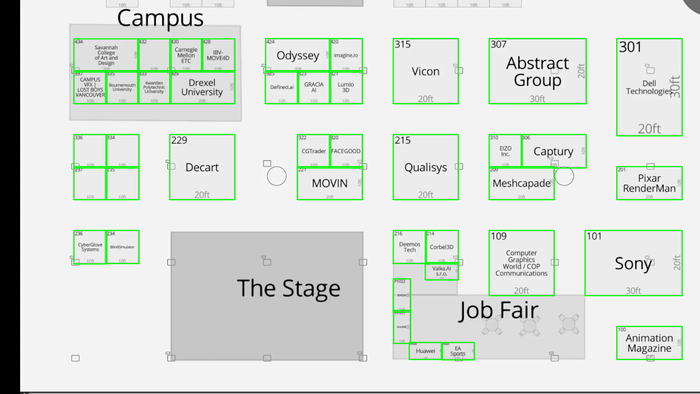

In [45]:
import cv2
import numpy as np
size_threshold = 45
bboxs = []
frame_show = cv2.cvtColor((orig*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
for idx in range(len(frames)):
    diff = np.abs(frames[idx]-orig)
    kernel = np.ones((7, 7), np.uint8)
    thresh = (diff > 0.1).astype(np.uint8) * 255
    eroded = cv2.erode(thresh, kernel, iterations=1)
    x, y, w, h = cv2.boundingRect(eroded)
    if w < size_threshold or h < size_threshold:
        continue
    
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w >= size_threshold and h >= size_threshold:
            bboxs.append([x, y, w, h])
            # print(x, y, w, h)
            # media.show_images([thresh[y:y+h, x:x+w], eroded[y:y+h, x:x+w], frames[idx][y:y+h, x:x+w]], width=128)
            cv2.rectangle(frame_show, (x, y), (x+w, y+h), (0, 255, 0), 2)

print(len(bboxs))
media.show_image(frame_show, width=700)

In [ ]:
# size_threshold = np.percentile(np.array(bboxs)[:, -2:].flatten(), 5)
# bboxs = [b for b in bboxs if min(b[2], b[3]) >= size_threshold]

去重後的bbox數量: 41


""

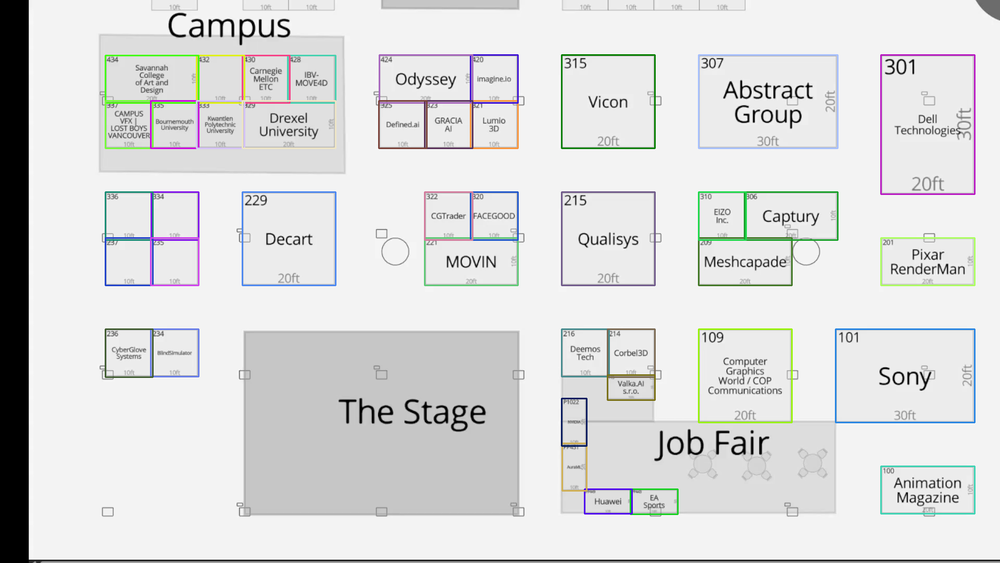

In [46]:
def iou(box1, box2):
    # box: [x, y, w, h]
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    inter_w = max(0, xi2 - xi1)
    inter_h = max(0, yi2 - yi1)
    inter_area = inter_w * inter_h
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area
    if union_area == 0:
        return 0
    return inter_area / union_area

dedup_bboxs = []
used = [False] * len(bboxs)
for i in range(len(bboxs)):
    if used[i]:
        continue
    box1 = bboxs[i]
    dedup_bboxs.append(box1)
    for j in range(i+1, len(bboxs)):
        if used[j]:
            continue
        box2 = bboxs[j]
        if iou(box1, box2) > 0.5:
            used[j] = True

import random

frame_show = cv2.cvtColor((orig*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
for box in dedup_bboxs:
    x, y, w, h = box
    # 隨機產生顏色
    color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    cv2.rectangle(frame_show, (x, y), (x+w, y+h), color, 2)
    
print(f"去重後的bbox數量: {len(dedup_bboxs)}")
media.show_image(frame_show, width=1000)



In [65]:
import numpy as np


def apply_transform(bboxes_small, bbox_big, target_idx=0):
    """把小圖裡的一批 BBox 轉成大圖座標"""
    bboxes_small = np.array(bboxes_small, dtype=float)
    bbox_big = np.array(list(bbox_big), dtype=float).reshape(1, -1)
    
    bboxes_small[:, :2] = bboxes_small[:, :2] - bboxes_small[[target_idx], :2]
    scale = bbox_big[:, -2:] / bboxes_small[[target_idx], -2:]
    bboxes_small[:, :2] *= scale
    bboxes_small[:, 2:] *= scale
    bboxes_small[:, :2] = bboxes_small[:, :2] + bbox_big[[0], :2]
    bboxes_small_ = np.round(bboxes_small).astype(int)
    print((bboxes_small_-bboxes_small).max())
    print(bboxes_small[target_idx], bbox_big[0])
    return bboxes_small_

In [132]:
anchor_idx = 22
anchor_large = (5475, 5937, 185, 185)
# shifted_bboxs = apply_transform(dedup_bboxs,  anchor_large, anchor_idx)
# shifted_bboxs[:3]

In [139]:
# 以 bbox[0] 當作一個 grid unit (正方形)，推算其他 bbox 的 bbox 表示（以 unit 為基準）
unit_x, unit_y, unit_w, unit_h = dedup_bboxs[anchor_idx]
unit = 45
bbox_units = []
for box in dedup_bboxs:
    x, y, w, h = box
    gx = (x - unit_x) / unit
    gy = (y - unit_y) / unit
    gw = w / unit
    gh = h / unit
    bbox_units.append([gx, gy, gw, gh])
bbox_units = np.array(bbox_units)
bbox_units_raw = bbox_units.round(decimals=2)
bbox_units = np.round(np.array(bbox_units)).astype(int)
# print(bbox_units)

In [140]:
dedup_bboxs[anchor_idx], anchor_large

([903, 105, 91, 92], (5475, 5937, 185, 185))

In [145]:
box_origin = list(anchor_large)
box_origin[2] //= 2
box_origin[3] //= 2
box_origin[2] += 1
box_origin[3] += 1
box_origin

[5475, 5937, 93, 93]


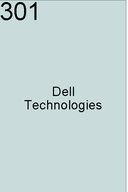
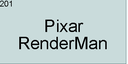
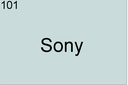
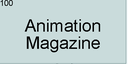
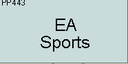
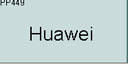
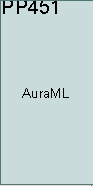
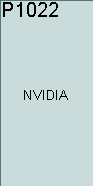
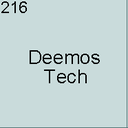
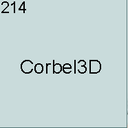
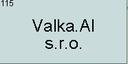
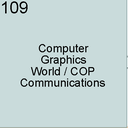
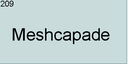
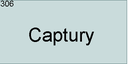
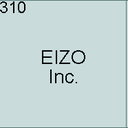
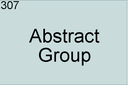
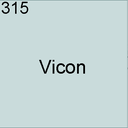
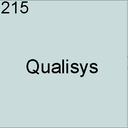
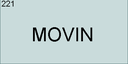
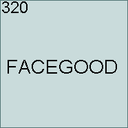
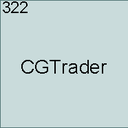
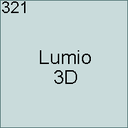
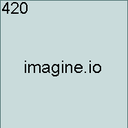
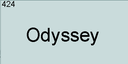
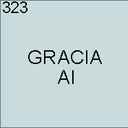
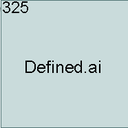
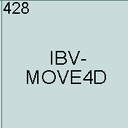
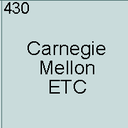
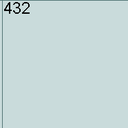
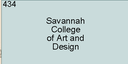
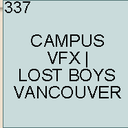
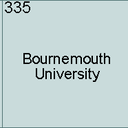
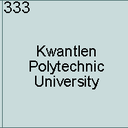
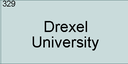
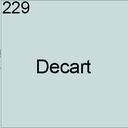
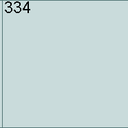
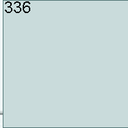
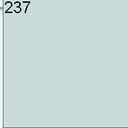
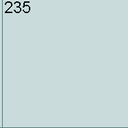
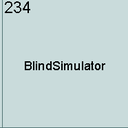
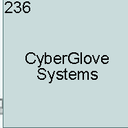

In [146]:
# 根據 dedup_bboxs 裡的 bbox，將 orig 影像裁切出來，存成 crops
crops = []
shifted_bboxs = []
# for box in dedup_bboxs:
for box in bbox_units:
    x, y, w, h = [i for i in box]
    
    # crop = orig[y:y+h, x:x+w]
    
    x = box_origin[0] + box_origin[2] * x
    y = box_origin[1] + box_origin[2] * y
    w *= box_origin[2]
    h *= box_origin[2]
    shifted_bboxs.append([x, y, w, h])
    crop = large_map[y:y+h, x:x+w]
    
    crops.append(crop)
media.show_images(crops, width=128, columns=8, border=True, titles=[f"{i}: {b}" for i, b in enumerate(bbox_units_raw)])


In [147]:
data = [
    {
        'name': "",
        'id': -1,
        'type': 'booth',
        'bbox': np.array(bbox).tolist(),
        'unit': np.array(unit).tolist(),
    }
    for bbox, unit in zip(shifted_bboxs, bbox_units)
]


In [148]:
import json
with open('../data/bboxes_2.json', 'w') as f:
    json.dump(data, f, indent=4)